# Практика: Computer Vision в реальном мире (Intro)

Этот ноутбук — практическое закрепление вводной лекции:
- виды задач CV: классификация, детекция, сегментация, трекинг, OCR, поиск похожего
- продовые боли: данные, domain shift, ложные срабатывания, скорость
- формат выхода моделей и базовые пайплайны инференса

**Правила:** выполняйте код в ячейках `YOUR CODE HERE`, не меняйте тестовые ячейки.  
Итог: `TOTAL POINTS / 100`.


In [38]:
# @title 1) Student Info & Config
STUDENT_NAME = "FAMILIYA IMYA OTCHESTVO"  # @param {type:"string"}
GROUP = "11-101"         # @param {type:"string"}
ASSIGMENT = "CV_REAL_WORLD_PRACTICE"
SEED = 42
START_DATE = "2026-02-17"
DUE_DATE = "2026-03-03"


In [2]:
# @title 2) Installs (Colab)
# Если вы запускаете в Google Colab — эта ячейка поставит зависимости.
# Если запускаете локально и всё уже установлено — можно пропустить.

import sys, os, subprocess, textwrap

def _run(cmd):
    print(" ".join(cmd))
    subprocess.check_call(cmd)

IN_COLAB = "google.colab" in sys.modules or "COLAB_GPU" in os.environ

if IN_COLAB:
    # ultralytics (YOLO), pytesseract, opencv
    _run([sys.executable, "-m", "pip", "install", "-q", "ultralytics", "pytesseract", "opencv-python"])
    # tesseract binary
    _run(["bash", "-lc", "apt-get -qq update && apt-get -qq install -y tesseract-ocr > /dev/null"])
else:
    print("Not running in Colab — skipping installs.")


Not running in Colab — skipping installs.


In [3]:
# @title 3) Imports
import os, sys, math, json, random, time
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

import numpy as np

from PIL import Image, ImageDraw, ImageFont
import requests

import torch
import torch.nn.functional as F


In [30]:
# @title 4) Global score storage (do not modify)
SCORES = {}

def _set_score(task_name, points, max_points):
    SCORES[task_name] = min(points, max_points)
    total = sum(SCORES.values())
    print(f"Task {task_name}: {SCORES[task_name]} / {max_points} points")
    print(f"TOTAL POINTS: {total} / 100\n")
    return total


In [5]:
# @title 5) Utils: download image
def load_image_from_urls(urls: List[str], timeout: int = 20) -> Image.Image:
    """Try multiple URLs, return PIL.Image."""
    last_err = None
    for url in urls:
        try:
            r = requests.get(url, timeout=timeout)
            r.raise_for_status()
            img = Image.open(io.BytesIO(r.content)).convert("RGB")
            return img
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Failed to download image from all URLs. Last error: {last_err}")

import io

BUS_URLS = [
    "https://ultralytics.com/images/bus.jpg",
    "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg",
]
DOG_URLS = [
    "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg",
    "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg?raw=1",
]
ZIDANE_URLS = [
    "https://ultralytics.com/images/zidane.jpg",
    "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/zidane.jpg",
]


## Task 1 (15 points): Классифицируйте постановки задач

Ниже 10 утверждений. Для каждого укажите тип задачи из списка:

`"classification"`, `"detection"`, `"segmentation"`, `"tracking"`, `"ocr"`, `"retrieval"`

Впишите ответы в список `answers` в том же порядке.

**Важно:** Task 1 проверяется только при сдаче. Локально проверяется лишь формат ответа; баллы начисляются на стороне проверяющего скрипта.


In [6]:
# YOUR CODE HERE: Task 1
statements = [
    "Определить, есть ли на фото дефект на детали.",
    "Найти на кадре всех людей и вернуть координаты рамок.",
    "Выделить точную область опухоли на МРТ по пикселям.",
    "Посчитать, сколько человек пересекло линию входа на видео.",
    "Считать текст суммы и даты с фото чека.",
    "Найти 10 самых похожих товаров на изображение-образец.",
    "Определить тип товара по фото: напиток, снеки или бытовая химия.",
    "Найти на фото номера машин и вернуть рамки + распознанный текст.",
    "Разметить пиксели дороги и неба для автопилота.",
    "Отследить один и тот же автомобиль по кадрам и построить траекторию."
]

answers = [
    # например: "classification",
]


In [7]:
# TEST CELL: Task 1 (15 points with key file)
# По умолчанию (у студентов) ключа нет — тогда за Task 1 будет 0 баллов.
# При проверке преподаватель/ассистент кладёт файл ключа в /content,
# и ноутбук сам начисляет баллы. Внешний проверяющий скрипт ничего про это не знает.

import json, os

allowed = {"classification","detection","segmentation","tracking","ocr","retrieval"}

# 1) Проверка формата ответа (выполняется всегда)
format_ok = True
msg = []
try:
    if not isinstance(answers, list):
        format_ok = False
        msg.append("answers должен быть списком (list).")
    else:
        if len(answers) != len(statements):
            format_ok = False
            msg.append(f"Ожидается {len(statements)} ответов, получено {len(answers)}.")
        else:
            for i, a in enumerate(answers, 1):
                a_norm = str(a).strip().lower()
                if a_norm not in allowed:
                    format_ok = False
                    msg.append(f"Ответ #{i} вне допустимого набора: {a!r}.")
except Exception as e:
    format_ok = False
    msg.append(f"Ошибка при проверке формата: {e}")

if not format_ok:
    print("Task 1: формат не ок:")
    for m in msg:
        print("-", m)
    _set_score("task1", 0, 15)
else:
    print("Task 1: формат ок.")

    # 2) Пытаемся найти ключ (если ключа нет — баллы = 0)
    KEY_NAME = "CV_Real_World_Practice_key.json"
    candidate_paths = [
        KEY_NAME,
        f"/content/{KEY_NAME}",
        f"/content/drive/MyDrive/{KEY_NAME}",
    ]
    key_path = next((p for p in candidate_paths if os.path.exists(p)), None)

    if key_path is None:
        print("Ключ не найден. Баллы за Task 1 = 0 (это нормально для локального прогона).")
        _set_score("task1", 0, 15)
    else:
        try:
            with open(key_path, "r", encoding="utf-8") as f:
                key = json.load(f)
            expected = key.get("task1", {}).get("expected_answers", None)

            if not isinstance(expected, list) or len(expected) != len(statements):
                print("Ключ найден, но формат не соответствует ожидаемому. Баллы за Task 1 = 0.")
                _set_score("task1", 0, 15)
            else:
                # 3) Начисляем баллы пропорционально числу правильных ответов
                correct = 0
                for a, e in zip(answers, expected):
                    if str(a).strip().lower() == str(e).strip().lower():
                        correct += 1

                points_per = 15 / len(expected)
                score = round(correct * points_per, 2)

                print(f"Ключ найден: начисляю баллы за Task 1. Правильных: {correct}/{len(expected)} → {score}/15")
                _set_score("task1", score, 15)

        except Exception as e:
            print(f"Ошибка чтения/применения ключа: {e}. Баллы за Task 1 = 0.")
            _set_score("task1", 0, 15)


Task 1: формат не ок:
- Ожидается 10 ответов, получено 0.
Task task1: 0 / 15 points
TOTAL POINTS: 0 / 100



## Task 2 (15 points): Классификация (pretrained model)

Нужно реализовать функцию `imagenet_top1_label(img: PIL.Image) -> str`:
- использует pretrained модель из `torchvision` (ResNet-18 или аналог)
- применяет правильные transforms из `weights.transforms()`
- возвращает **строку** с названием top-1 класса

Подсказка: категории лежат в `weights.meta["categories"]`.


In [8]:
# Imports for torchvision models (may take a moment)
import torchvision
from torchvision.models import resnet18, ResNet18_Weights


In [9]:
# YOUR CODE HERE: Task 2
def imagenet_top1_label(img: Image.Image) -> str:
    """Return top-1 ImageNet label string for a PIL image."""
    # 1) load weights + model
    # 2) preprocess with weights.transforms()
    # 3) forward pass (no grad)
    # 4) argmax -> label string
    raise NotImplementedError


In [10]:
# TEST CELL: Task 2 (15 points)
img = load_image_from_urls(DOG_URLS)
pts = 0
try:
    label = imagenet_top1_label(img)
    if isinstance(label, str) and len(label.strip()) > 0 and len(label) < 80:
        pts = 15
except Exception as e:
    print("Error:", e)
    pts = 0

_set_score("2", pts, 15)


Error: 
Task 2: 0 / 15 points
TOTAL POINTS: 0 / 100



## Task 3 (20 points): Детекция (YOLO)

Нужно реализовать `count_people_yolo(img: PIL.Image, conf=0.25) -> int`:
- использует `ultralytics.YOLO` (предобученная модель, например `yolov8n.pt`)
- делает инференс по `img`
- считает, сколько детекций класса **person** с confidence >= conf

Важно: возвращайте **int**.


In [11]:
from ultralytics import YOLO


In [12]:
# YOUR CODE HERE: Task 3
def count_people_yolo(img: Image.Image, conf: float = 0.25) -> int:
    """Count 'person' detections using YOLO."""
    # 1) load YOLO once (можно кэшировать глобально)
    # 2) run prediction
    # 3) filter by class 'person' and confidence
    raise NotImplementedError


In [13]:
# TEST CELL: Task 3 (20 points)
img = load_image_from_urls(BUS_URLS)
pts = 0
try:
    n = count_people_yolo(img, conf=0.25)
    if isinstance(n, int) and n >= 1 and n < 200:
        pts = 20
except Exception as e:
    print("Error:", e)
    pts = 0

_set_score("3", pts, 20)


Error: 
Task 3: 0 / 20 points
TOTAL POINTS: 0 / 100



## Task 4 (20 points): Сегментация (semantic segmentation)

Нужно реализовать `person_pixel_ratio(img: PIL.Image) -> float`:
- использовать pretrained `deeplabv3_resnet50` из `torchvision`
- применить transforms из весов
- получить предсказанную маску классов (argmax)
- найти индекс класса `"person"` из `weights.meta["categories"]`
- вернуть долю пикселей класса person: число от 0 до 1

Важно: возвращайте **float**.


In [14]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights


In [15]:
# YOUR CODE HERE: Task 4
def person_pixel_ratio(img: Image.Image) -> float:
    """Return fraction of pixels predicted as 'person' by a pretrained semantic segmentation model."""
    raise NotImplementedError


In [16]:
# TEST CELL: Task 4 (20 points)
img = load_image_from_urls(ZIDANE_URLS)  # people in the frame
pts = 0
try:
    r = float(person_pixel_ratio(img))
    # ожидаем, что людей не ноль и не весь кадр
    if 0.001 <= r <= 0.8:
        pts = 20
    else:
        print("Suspicious ratio:", r)
except Exception as e:
    print("Error:", e)
    pts = 0

_set_score("4", pts, 20)


Error: 
Task 4: 0 / 20 points
TOTAL POINTS: 0 / 100



## Task 5 (15 points): OCR на синтетическом изображении

Нужно реализовать `ocr_read_text(img: PIL.Image) -> str`:
- использовать `pytesseract.image_to_string`
- вернуть распознанный текст (строку)

Мы создаём картинку с текстом сами, чтобы было стабильно.


In [26]:
import pytesseract


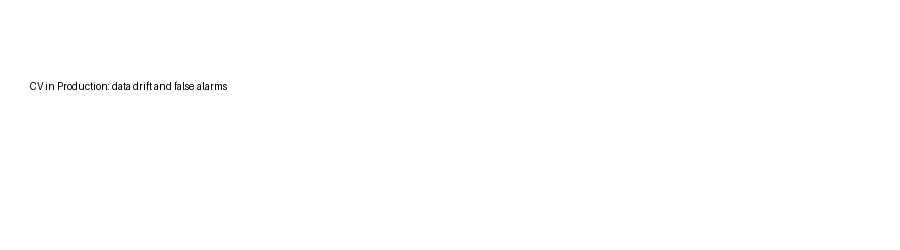

In [27]:
# Synthetic image generator (do not modify)
def make_text_image(text: str, w: int = 900, h: int = 250) -> Image.Image:
    img = Image.new("RGB", (w, h), "white")
    draw = ImageDraw.Draw(img)
    # default font (works in Colab)
    draw.text((30, 80), text, fill="black")
    return img

ocr_test_img = make_text_image("CV in Production: data drift and false alarms")
ocr_test_img


In [28]:
# YOUR CODE HERE: Task 5
def ocr_read_text(img: Image.Image) -> str:
    """Return OCR text from image."""
    raise NotImplementedError


In [29]:
# TEST CELL: Task 5 (15 points)
pts = 0
try:
    s = ocr_read_text(ocr_test_img)
    s_low = str(s).lower()
    if ("production" in s_low) and ("false" in s_low or "alarm" in s_low):
        pts = 15
    else:
        print("OCR output:", s)
except Exception as e:
    print("Error:", e)
    pts = 0

_set_score("5", pts, 15)


Error: 
Task 5: 0 / 15 points
TOTAL POINTS: 0 / 100



## Task 6 (15 points): Поиск похожего (embeddings + cosine similarity)

Нужно реализовать `retrieve_most_similar(query, gallery) -> int`:
- получить эмбеддинг для query и каждого изображения в gallery
- посчитать cosine similarity
- вернуть индекс самого похожего изображения в gallery

Подсказка: эмбеддинг можно взять из ResNet-18, убрав последний классификатор.


In [21]:
# Helper: make a 'query' as a flipped bus image
bus = load_image_from_urls(BUS_URLS)
query = bus.transpose(Image.FLIP_LEFT_RIGHT)
gallery = [bus, load_image_from_urls(DOG_URLS)]


In [22]:
# YOUR CODE HERE: Task 6
def retrieve_most_similar(query: Image.Image, gallery: List[Image.Image]) -> int:
    """Return index of most similar image in gallery (cosine similarity)."""
    raise NotImplementedError


In [33]:
# TEST CELL: Task 6 (15 points)
pts = 0
try:
    idx = retrieve_most_similar(query, gallery)
    if isinstance(idx, int) and idx == 0:
        pts = 15
    else:
        print("Got idx:", idx, "Expected 0")
except Exception as e:
    print("Error:", e)
    pts = 0

total = _set_score("6", pts, 15)


Error: 
Task 6: 0 / 15 points
TOTAL POINTS: 0 / 100



In [41]:
def penalty_fraction(start_dt, due_dt, now_dt) -> float:
    if not (start_dt and due_dt and now_dt):
        return 0.0
    window = _sec(due_dt - start_dt)
    if window <= 0:
        return 1.0 if now_dt > due_dt else 0.0
    late = max(0.0, _sec(now_dt - due_dt))
    return min(1.0, late / window)

In [42]:
# применяем штраф
try:
    pf = penalty_fraction(start_dt, due_dt, submission_dt)
except NameError:
    from datetime import timezone
    pf = 0.0
final_score = max(0.0, total * (1.0 - min(1.0, pf)))
print(final_score)

0.0


## Финал

Если у вас `TOTAL POINTS: 100 / 100`, значит базовые пайплайны инференса у вас получились.

Дальше по курсу мы будем:
- усложнять данные и метрики
- учиться разбирать ошибки (FP/FN)
- готовить модели к продовому сценарию: скорость, стабильность, мониторинг

**Важно:** локально максимум — **85/100**, потому что **Task 1** оценивается только при проверке после отправки.


In [39]:
import json
final = {
    "name": STUDENT_NAME,
    "group": GROUP,
    "assignment":ASSIGMENT,
    "score": float(total),
    "penalty_score": float(final_score),
    "due_date": DUE_DATE,
    "start_date": START_DATE,
}


In [40]:
print(json.dumps(final, ensure_ascii=False))

{"name": "FAMILIYA IMYA OTCHESTVO", "group": "11-101", "assignment": "CV_REAL_WORLD_PRACTICE", "score": 0.0, "due_date": "2026-03-03", "start_date": "2026-02-17"}
